# Association Rule Mining

Market basket analysis using Apriori and FP-Growth algorithms.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

---
## Sample Transaction Data

In [2]:
# Simulated grocery store transactions
transactions = [
    ['milk', 'bread', 'butter'],
    ['bread', 'butter', 'eggs'],
    ['milk', 'bread', 'butter', 'eggs'],
    ['bread', 'eggs'],
    ['milk', 'bread', 'butter', 'cheese'],
    ['milk', 'bread'],
    ['bread', 'butter'],
    ['milk', 'bread', 'butter', 'eggs', 'cheese'],
    ['milk', 'butter', 'eggs'],
    ['bread', 'butter', 'eggs', 'cheese'],
    ['milk', 'bread', 'butter'],
    ['bread', 'eggs', 'cheese'],
    ['milk', 'bread', 'eggs'],
    ['butter', 'eggs'],
    ['milk', 'bread', 'butter', 'eggs'],
]

print(f'Total transactions: {len(transactions)}')
print(f'Sample transactions:')
for i, t in enumerate(transactions[:5]):
    print(f'  {i+1}: {t}')

Total transactions: 15
Sample transactions:
  1: ['milk', 'bread', 'butter']
  2: ['bread', 'butter', 'eggs']
  3: ['milk', 'bread', 'butter', 'eggs']
  4: ['bread', 'eggs']
  5: ['milk', 'bread', 'butter', 'cheese']


---
## Prepare Data for Mining

In [3]:
# One-hot encode transactions
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df = pd.DataFrame(te_array, columns=te.columns_)

print('One-hot encoded transactions:')
print(df)

One-hot encoded transactions:
    bread  butter  cheese   eggs   milk
0    True    True   False  False   True
1    True    True   False   True  False
2    True    True   False   True   True
3    True   False   False   True  False
4    True    True    True  False   True
5    True   False   False  False   True
6    True    True   False  False  False
7    True    True    True   True   True
8   False    True   False   True   True
9    True    True    True   True  False
10   True    True   False  False   True
11   True   False    True   True  False
12   True   False   False   True   True
13  False    True   False   True  False
14   True    True   False   True   True


---
## Find Frequent Itemsets with Apriori

In [4]:
# Apply Apriori algorithm
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)

print('='*60)
print('FREQUENT ITEMSETS (Support >= 30%)')
print('='*60)
print(frequent_itemsets.sort_values('support', ascending=False).to_string(index=False))

FREQUENT ITEMSETS (Support >= 30%)
 support              itemsets  length
0.866667               (bread)       1
0.733333              (butter)       1
0.666667                (eggs)       1
0.600000                (milk)       1
0.600000       (butter, bread)       2
0.533333         (eggs, bread)       2
0.533333         (milk, bread)       2
0.466667        (eggs, butter)       2
0.466667        (milk, butter)       2
0.400000 (milk, butter, bread)       3
0.333333          (eggs, milk)       2
0.333333 (eggs, butter, bread)       3


---
## Generate Association Rules

In [5]:
# Generate rules with minimum confidence
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

print('='*60)
print('ASSOCIATION RULES (Confidence >= 60%)')
print('='*60)
print(rules.sort_values('lift', ascending=False).to_string(index=False))

ASSOCIATION RULES (Confidence >= 60%)
    antecedents     consequents  support  confidence     lift
(butter, bread)          (milk) 0.400000    0.666667 1.111111
         (milk) (butter, bread) 0.400000    0.666667 1.111111
       (butter)          (milk) 0.466667    0.636364 1.060606
         (milk)        (butter) 0.466667    0.777778 1.060606
         (milk)         (bread) 0.533333    0.888889 1.025641
        (bread)          (milk) 0.533333    0.615385 1.025641
  (milk, bread)        (butter) 0.400000    0.750000 1.022727
 (milk, butter)         (bread) 0.400000    0.857143 0.989011
         (eggs)        (butter) 0.466667    0.700000 0.954545
       (butter)          (eggs) 0.466667    0.636364 0.954545
       (butter)         (bread) 0.600000    0.818182 0.944056
        (bread)        (butter) 0.600000    0.692308 0.944056
         (eggs)         (bread) 0.533333    0.800000 0.923077
        (bread)          (eggs) 0.533333    0.615385 0.923077
  (eggs, bread)        (butter) 

---
## Visualize Rules

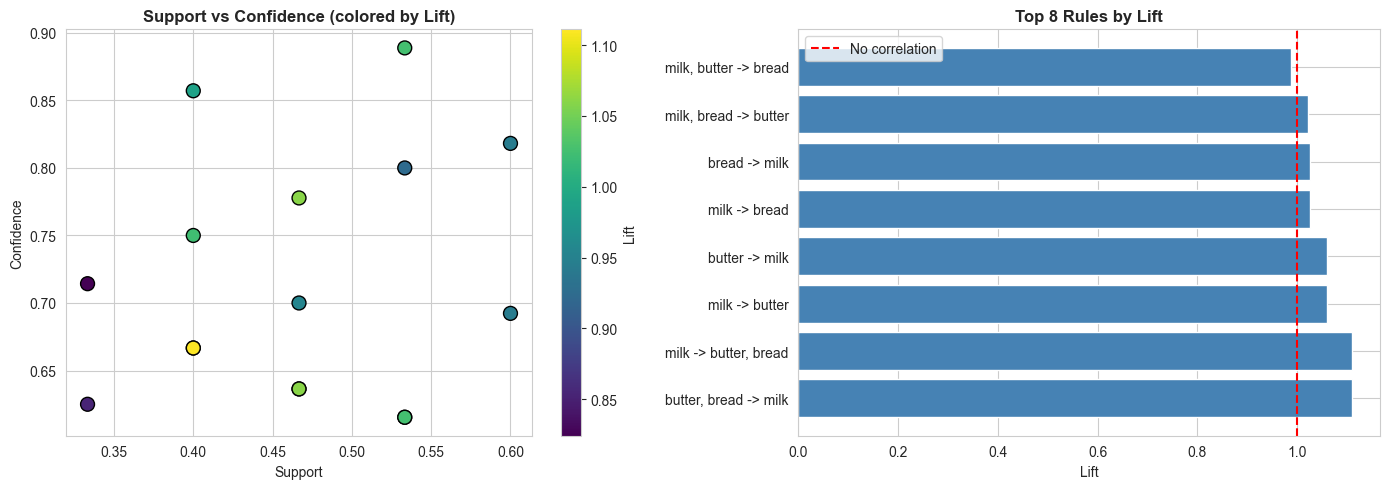

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Support vs Confidence scatter
scatter = axes[0].scatter(rules['support'], rules['confidence'], 
                         c=rules['lift'], cmap='viridis', s=100, edgecolors='k')
axes[0].set_xlabel('Support')
axes[0].set_ylabel('Confidence')
axes[0].set_title('Support vs Confidence (colored by Lift)', fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Lift')

# Top rules by Lift
top_rules = rules.nlargest(8, 'lift')
rule_labels = [f"{', '.join(list(r['antecedents']))} -> {', '.join(list(r['consequents']))}" 
               for _, r in top_rules.iterrows()]
axes[1].barh(range(len(top_rules)), top_rules['lift'], color='steelblue')
axes[1].set_yticks(range(len(top_rules)))
axes[1].set_yticklabels(rule_labels)
axes[1].set_xlabel('Lift')
axes[1].set_title('Top 8 Rules by Lift', fontweight='bold')
axes[1].axvline(x=1.0, color='red', linestyle='--', label='No correlation')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## Compare Apriori vs FP-Growth

In [7]:
import time

# Larger synthetic dataset
np.random.seed(42)
items = ['milk', 'bread', 'butter', 'eggs', 'cheese', 'yogurt', 'juice', 'apples', 'bananas', 'cereal']
large_transactions = []
for _ in range(1000):
    n_items = np.random.randint(2, 7)
    transaction = list(np.random.choice(items, n_items, replace=False))
    large_transactions.append(transaction)

te_large = TransactionEncoder()
df_large = pd.DataFrame(te_large.fit_transform(large_transactions), columns=te_large.columns_)

# Time Apriori
start = time.time()
apriori_result = apriori(df_large, min_support=0.1, use_colnames=True)
apriori_time = time.time() - start

# Time FP-Growth
start = time.time()
fpgrowth_result = fpgrowth(df_large, min_support=0.1, use_colnames=True)
fpgrowth_time = time.time() - start

print('='*60)
print('ALGORITHM COMPARISON (1000 transactions)')
print('='*60)
print(f'Apriori:   {apriori_time:.4f}s, {len(apriori_result)} frequent itemsets')
print(f'FP-Growth: {fpgrowth_time:.4f}s, {len(fpgrowth_result)} frequent itemsets')
print(f'Speedup:   {apriori_time/fpgrowth_time:.2f}x')

ALGORITHM COMPARISON (1000 transactions)
Apriori:   0.0030s, 55 frequent itemsets
FP-Growth: 0.0054s, 55 frequent itemsets
Speedup:   0.56x


---
## Practical Interpretation

In [8]:
# Find actionable rules
actionable = rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.5)].copy()
actionable = actionable.sort_values('lift', ascending=False)

print('='*60)
print('ACTIONABLE INSIGHTS (Lift > 1.2, Confidence > 50%)')
print('='*60)
for _, row in actionable.head(5).iterrows():
    ant = ', '.join(list(row['antecedents']))
    con = ', '.join(list(row['consequents']))
    print(f'\nRule: {ant} -> {con}')
    print(f'  - Support: {row["support"]:.1%} of transactions contain both')
    print(f'  - Confidence: {row["confidence"]:.1%} of {ant} buyers also buy {con}')
    print(f'  - Lift: {row["lift"]:.2f}x more likely than random')

ACTIONABLE INSIGHTS (Lift > 1.2, Confidence > 50%)


---
## Summary

**Key Points:**
- Association rule mining finds co-occurrence patterns in transaction data
- Support measures frequency, Confidence measures conditional probability
- Lift indicates true correlation strength (>1 = positive correlation)
- Apriori uses candidate generation, FP-Growth uses tree structure
- Rules are useful for recommendations and cross-selling

**Key Point:** "Association rules with high lift and reasonable support reveal truly correlated items, enabling effective product recommendations and inventory placement."

In [9]:
print('\nNotebook completed successfully.')


Notebook completed successfully.
